# Movie Recommendation System
# Dataset: MovieLens 20M Subset (2010–2015)

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.sparse import csr_matrix
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

# PART 1: MAIN TASK - USER-BASED COLLABORATIVE FILTERING


In [50]:
def load_and_explore_data(file_path):
    """
    Load movie ratings data and perform comprehensive EDA.

    Concept: Understanding data structure is crucial before building any model.
    We need to know the scale, distribution, and sparsity to make informed decisions.
    """

    # Load the data
    print("Loading data...")
    ratings_df = pd.read_csv(file_path)

    # Basic info about the dataset
    print(f"Dataset shape: {ratings_df.shape}")
    print(f"Columns: {list(ratings_df.columns)}")
    print("\nFirst 5 rows:")
    print(ratings_df.head())

    # Calculate key statistics
    n_users = ratings_df['userId'].nunique()
    n_movies = ratings_df['movieId'].nunique()
    n_ratings = len(ratings_df)

    print(f"\nDataset Statistics:")
    print(f"Number of unique users: {n_users:,}")
    print(f"Number of unique movies: {n_movies:,}")
    print(f"Total ratings: {n_ratings:,}")

    # Calculate sparsity
    possible_ratings = n_users * n_movies
    sparsity = (1 - (n_ratings / possible_ratings)) * 100
    print(f"Dataset sparsity: {sparsity:.2f}%")

    # Rating distribution
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    ratings_df['rating'].hist(bins=10, edgecolor='black')
    plt.title('Distribution of Movie Ratings')
    plt.xlabel('Rating')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    user_rating_counts = ratings_df['userId'].value_counts()
    plt.hist(user_rating_counts, bins=50, edgecolor='black')
    plt.title('Distribution of Ratings per User')
    plt.xlabel('Number of Ratings')
    plt.ylabel('Number of Users')
    plt.yscale('log')

    plt.tight_layout()
    plt.show()

    return ratings_df

In [51]:


def create_user_item_matrix(ratings_df, min_ratings=30):
    """
    Create a sparse user-item utility matrix.

    Concept: The user-item matrix is the foundation of collaborative filtering.
    Each row represents a user, each column a movie, and values are ratings.
    We use sparse matrices to handle the high sparsity efficiently.
    """

    # Filter users with minimum ratings to reduce noise
    user_counts = ratings_df['userId'].value_counts()
    active_users = user_counts[user_counts >= min_ratings].index
    filtered_df = ratings_df[ratings_df['userId'].isin(active_users)]

    print(f"Filtered to {len(active_users)} users with at least {min_ratings} ratings")
    print(f"Remaining ratings: {len(filtered_df):,}")

    # Create user and movie mappings
    unique_users = sorted(filtered_df['userId'].unique())
    unique_movies = sorted(filtered_df['movieId'].unique())

    user_to_idx = {user: idx for idx, user in enumerate(unique_users)}
    movie_to_idx = {movie: idx for idx, movie in enumerate(unique_movies)}

    # Create the sparse matrix
    rows = [user_to_idx[user] for user in filtered_df['userId']]
    cols = [movie_to_idx[movie] for movie in filtered_df['movieId']]
    data = filtered_df['rating'].values

    user_item_matrix = csr_matrix(
        (data, (rows, cols)),
        shape=(len(unique_users), len(unique_movies))
    )

    print(f"User-item matrix shape: {user_item_matrix.shape}")
    print(f"Matrix sparsity: {(1 - user_item_matrix.nnz / (user_item_matrix.shape[0] * user_item_matrix.shape[1])) * 100:.2f}%")

    return user_item_matrix, user_to_idx, movie_to_idx, unique_users, unique_movies

In [52]:
def calculate_cosine_similarity(user_item_matrix):
    """
    Calculate cosine similarity between users.

    Concept: Cosine similarity measures the angle between rating vectors.
    It's good for comparing users regardless of their rating scale preferences.
    """
    print("Calculating cosine similarity matrix...")
    cosine_sim = cosine_similarity(user_item_matrix)
    print(f"Similarity matrix shape: {cosine_sim.shape}")
    return cosine_sim

def calculate_pearson_similarity(user_item_matrix):
    """
    Calculate Pearson correlation between users.

    Concept: Pearson correlation measures linear correlation after mean-centering.
    It's better at handling users who consistently rate higher or lower than average.
    """
    print("Calculating Pearson correlation matrix...")

    # Convert to dense for correlation calculation (for small subsets)
    matrix_dense = user_item_matrix.toarray()
    n_users = matrix_dense.shape[0]
    pearson_sim = np.zeros((n_users, n_users))

    # Calculate correlation for each pair (this is computationally intensive)
    print("Note: Pearson calculation is intensive. Using sample for demonstration...")
    sample_size = min(100, n_users)  # Use subset for demo

    for i in range(sample_size):
        for j in range(i, sample_size):
            # Find common rated items
            mask = (matrix_dense[i] > 0) & (matrix_dense[j] > 0)
            if np.sum(mask) > 1:  # Need at least 2 common ratings
                corr, _ = pearsonr(matrix_dense[i][mask], matrix_dense[j][mask])
                pearson_sim[i, j] = pearson_sim[j, i] = corr if not np.isnan(corr) else 0

    print(f"Pearson similarity matrix shape (sample): {sample_size}x{sample_size}")
    return pearson_sim[:sample_size, :sample_size]

In [53]:
def predict_user_ratings(user_idx, user_item_matrix, similarity_matrix, k_neighbors=75):
    """
    Predict ratings for unrated movies using weighted average of similar users.

    Concept: We find the most similar users and use their ratings to predict
    what the target user might rate unrated movies.
    """

    # Get similarity scores for the target user
    user_similarities = similarity_matrix[user_idx]

    # Find top k similar users (excluding the user themselves)
    similar_users = np.argsort(user_similarities)[::-1][1:k_neighbors+1]

    # Get ratings from similar users
    user_ratings = user_item_matrix[user_idx].toarray().flatten()
    unrated_items = np.where(user_ratings == 0)[0]

    predictions = {}

    for item_idx in unrated_items:
        weighted_sum = 0
        similarity_sum = 0

        for similar_user in similar_users:
            similar_user_rating = user_item_matrix[similar_user, item_idx]
            similarity_score = user_similarities[similar_user]

            if similar_user_rating > 0 and similarity_score > 0:
                weighted_sum += similarity_score * similar_user_rating
                similarity_sum += similarity_score

        if similarity_sum > 0:
            predictions[item_idx] = weighted_sum / similarity_sum

    return predictions

def get_top_n_recommendations(user_idx, user_item_matrix, similarity_matrix,
                             unique_movies, n=10):
    """
    Generate top N movie recommendations for a user.
    """

    predictions = predict_user_ratings(user_idx, user_item_matrix, similarity_matrix)

    # Sort predictions by rating and get top N
    top_items = sorted(predictions.items(), key=lambda x: x[1], reverse=True)[:n]

    recommendations = []
    for item_idx, predicted_rating in top_items:
        movie_id = unique_movies[item_idx]
        recommendations.append({
            'movieId': movie_id,
            'predicted_rating': predicted_rating
        })

    return recommendations

In [54]:
def create_train_test_split(user_item_matrix, test_ratio=0.2):
    """
    Create train-test split for recommendation evaluation.

    Concept: We hide some existing ratings to test if our model can predict them.
    This simulates real-world scenario where we predict future preferences.
    """

    train_matrix = user_item_matrix.copy()
    test_matrix = csr_matrix(user_item_matrix.shape)

    # For each user, randomly select some ratings for testing
    for user_idx in range(user_item_matrix.shape[0]):
        user_ratings = user_item_matrix[user_idx].nonzero()[1]

        if len(user_ratings) > 5:  # Only if user has enough ratings
            n_test = max(1, int(len(user_ratings) * test_ratio))
            test_items = np.random.choice(user_ratings, n_test, replace=False)

            for item_idx in test_items:
                # Move rating from train to test
                rating = train_matrix[user_idx, item_idx]
                test_matrix[user_idx, item_idx] = rating
                train_matrix[user_idx, item_idx] = 0

    return train_matrix, test_matrix

def calculate_precision_at_k(user_idx, train_matrix, test_matrix, similarity_matrix,unique_movies, k=10, threshold=3.5):
    """
    Calculate Precision@K for a single user.

    Concept: Precision@K measures how many of our top K recommendations
    are actually relevant (highly rated) by the user.
    """

    # Get recommendations based on training data
    predictions = predict_user_ratings(user_idx, train_matrix, similarity_matrix)

    if not predictions:
        return 0

    # Get top K recommendations
    top_k_items = sorted(predictions.items(), key=lambda x: x[1], reverse=True)[:k]
    top_k_item_indices = [item[0] for item in top_k_items]

    # Check how many are relevant in test set
    relevant_items = 0
    for item_idx in top_k_item_indices:
        test_rating = test_matrix[user_idx, item_idx]
        if test_rating >= threshold:  # Consider rating >= 3.5 as relevant
            relevant_items += 1

    precision = relevant_items / k if k > 0 else 0
    return precision

def evaluate_system(user_item_matrix, similarity_matrix, unique_movies, k_values=[5, 10, 20]):
    """
    Evaluate the recommendation system using Precision@K.
    """

    print("Creating train-test split...")
    train_matrix, test_matrix = create_train_test_split(user_item_matrix)

    results = {}

    for k in k_values:
        print(f"\nEvaluating Precision@{k}...")
        precisions = []

        # Evaluate for a sample of users (for computational efficiency)
        sample_users = np.random.choice(user_item_matrix.shape[0],
                                      min(100, user_item_matrix.shape[0]),
                                      replace=False)

        for user_idx in sample_users:
            if test_matrix[user_idx].nnz > 0:  # User has test ratings
                precision = calculate_precision_at_k(
                    user_idx, train_matrix, test_matrix,
                    similarity_matrix, unique_movies, k
                )
                precisions.append(precision)

        avg_precision = np.mean(precisions) if precisions else 0
        results[k] = avg_precision
        print(f"Average Precision@{k}: {avg_precision:.4f}")

    return results

# Bonus Task - Alternative Methodsasdasdasdadsasd

In [55]:
def create_item_based_system(user_item_matrix):
    """
    Create item-based collaborative filtering system.

    Concept: Instead of finding similar users, we find similar movies.
    This is often more stable because item preferences change less than user preferences.
    Item-based is preferred when there are more users than items.
    """

    print("Creating item-item similarity matrix...")

    # Transpose matrix to get item-user matrix
    item_user_matrix = user_item_matrix.T

    # Calculate item similarity
    item_similarity = cosine_similarity(item_user_matrix)

    print(f"Item-item similarity matrix shape: {item_similarity.shape}")

    return item_similarity

def item_based_recommendations(user_idx, user_item_matrix, item_similarity,
                              unique_movies, n=10):
    """
    Generate recommendations using item-based collaborative filtering.
    """

    user_ratings = user_item_matrix[user_idx].toarray().flatten()
    rated_items = np.nonzero(user_ratings)[0]
    unrated_items = np.where(user_ratings == 0)[0]

    predictions = {}

    for item_idx in unrated_items:
        weighted_sum = 0
        similarity_sum = 0

        for rated_item in rated_items:
            item_sim = item_similarity[item_idx, rated_item]
            user_rating = user_ratings[rated_item]

            if item_sim > 0:
                weighted_sum += item_sim * user_rating
                similarity_sum += abs(item_sim)

        if similarity_sum > 0:
            predictions[item_idx] = weighted_sum / similarity_sum

    # Get top N recommendations
    top_items = sorted(predictions.items(), key=lambda x: x[1], reverse=True)[:n]

    recommendations = []
    for item_idx, predicted_rating in top_items:
        movie_id = unique_movies[item_idx]
        recommendations.append({
            'movieId': movie_id,
            'predicted_rating': predicted_rating
        })

    return recommendations

In [56]:
def implement_svd_recommendations(user_item_matrix, unique_movies, n_components=50):
    """
    Implement SVD-based matrix factorization for recommendations.

    Concept: SVD decomposes the user-item matrix into latent factors.
    This helps handle sparsity by finding hidden patterns in user preferences.
    It can predict ratings for all user-movie pairs, not just similar ones.
    """

    print(f"Performing SVD with {n_components} components...")

    # Apply SVD
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    user_factors = svd.fit_transform(user_item_matrix)
    item_factors = svd.components_

    print(f"User factors shape: {user_factors.shape}")
    print(f"Item factors shape: {item_factors.shape}")
    print(f"Explained variance ratio: {svd.explained_variance_ratio_.sum():.4f}")

    # Reconstruct the full matrix
    reconstructed_matrix = np.dot(user_factors, item_factors)

    return reconstructed_matrix, svd

def svd_based_recommendations(user_idx, reconstructed_matrix, user_item_matrix,
                             unique_movies, n=10):
    """
    Generate recommendations using SVD reconstructed matrix.
    """

    # Get original ratings to exclude already rated items
    original_ratings = user_item_matrix[user_idx].toarray().flatten()
    predicted_ratings = reconstructed_matrix[user_idx]

    # Mask already rated items
    unrated_mask = original_ratings == 0
    unrated_predictions = predicted_ratings * unrated_mask

    # Get top N recommendations
    top_items_idx = np.argsort(unrated_predictions)[::-1][:n]

    recommendations = []
    for item_idx in top_items_idx:
        if unrated_predictions[item_idx] > 0:  # Only positive predictions
            movie_id = unique_movies[item_idx]
            recommendations.append({
                'movieId': movie_id,
                'predicted_rating': unrated_predictions[item_idx]
            })

    return recommendations

MOVIE RECOMMENDATION SYSTEM - COMPLETE PIPELINE
STEP 1: DATA LOADING AND EDA
Loading data...
Dataset shape: (3844256, 6)
Columns: ['userId', 'movieId', 'rating', 'title', 'imdbId', 'tmdbId']

First 5 rows:
   userId  movieId  rating                         title  imdbId   tmdbId
0   56257     3435     4.0       Double Indemnity (1944)   36775    996.0
1   95841     3863     3.5              Cell, The (2000)  209958   8843.0
2   95841     4725     3.5              Session 9 (2001)  261983  10972.0
3   95841     8644     4.0               I, Robot (2004)  343818   2048.0
4   95841    46976     3.5  Stranger than Fiction (2006)  420223   1262.0

Dataset Statistics:
Number of unique users: 30,777
Number of unique movies: 26,083
Total ratings: 3,844,256
Dataset sparsity: 99.52%


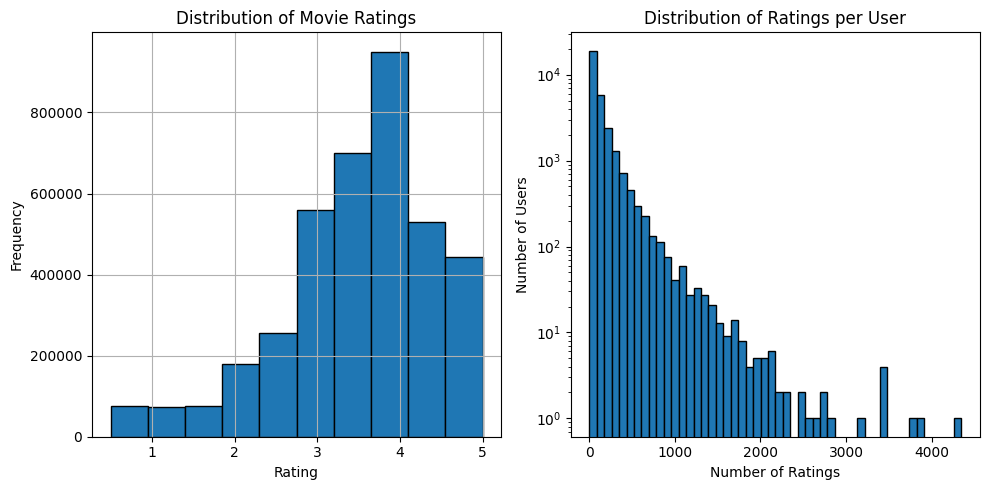

Creating sample data for demonstration...
Sample dataset created with 47574 ratings

STEP 2: DATA PREPARATION - USER-ITEM MATRIX
Filtered to 998 users with at least 30 ratings
Remaining ratings: 47,516
User-item matrix shape: (998, 500)
Matrix sparsity: 90.48%

STEP 3: USER SIMILARITY CALCULATION
Calculating cosine similarity matrix...
Similarity matrix shape: (998, 998)
Calculating Pearson correlation matrix...
Note: Pearson calculation is intensive. Using sample for demonstration...
Pearson similarity matrix shape (sample): 100x100

STEP 4: PREDICTIONS AND RECOMMENDATIONS

Generating recommendations for user 1:
Top 10 User-Based Recommendations:
1. Movie ID: 16, Predicted Rating: 5.00
2. Movie ID: 161, Predicted Rating: 5.00
3. Movie ID: 261, Predicted Rating: 5.00
4. Movie ID: 296, Predicted Rating: 5.00
5. Movie ID: 419, Predicted Rating: 5.00
6. Movie ID: 179, Predicted Rating: 4.84
7. Movie ID: 350, Predicted Rating: 4.71
8. Movie ID: 132, Predicted Rating: 4.70
9. Movie ID: 185,

In [57]:

def main():
    """
    Example of how to run the complete recommendation system.
    Replace 'movies-rating.csv' with your actual file path.
    """

    print("MOVIE RECOMMENDATION SYSTEM - COMPLETE PIPELINE")
    print("="*60)

    # Step 1: Load and explore data
    print("="*60)
    print("STEP 1: DATA LOADING AND EDA")
    print("="*60)

    ratings_df = load_and_explore_data('/content/drive/MyDrive/elevvo/Task 5/movies-rating.csv')

    # For demonstration, create sample data
    print("Creating sample data for demonstration...")
    np.random.seed(42)
    n_users_sample = 1000
    n_movies_sample = 500
    n_ratings_sample = 50000

    sample_data = {
        'userId': np.random.choice(range(1, n_users_sample + 1), n_ratings_sample),
        'movieId': np.random.choice(range(1, n_movies_sample + 1), n_ratings_sample),
        'rating': np.random.choice([1, 2, 3, 4, 5], n_ratings_sample,
                                 p=[0.1, 0.1, 0.2, 0.3, 0.3])
    }
    ratings_df = pd.DataFrame(sample_data)
    ratings_df = ratings_df.drop_duplicates(subset=['userId', 'movieId'])

    print(f"Sample dataset created with {len(ratings_df)} ratings")


    # Step 2: Data Preparation
    print("\n" + "="*60)
    print("STEP 2: DATA PREPARATION - USER-ITEM MATRIX")
    print("="*60)

    # Create user-item matrix
    user_item_matrix, user_to_idx, movie_to_idx, unique_users, unique_movies = create_user_item_matrix(ratings_df, min_ratings=30)


    # Step 3: Calculating User Similarity
    print("\n" + "="*60)
    print("STEP 3: USER SIMILARITY CALCULATION")
    print("="*60)

    cosine_sim = calculate_cosine_similarity(user_item_matrix)
    pearson_sim = calculate_pearson_similarity(user_item_matrix)


    # Step 4: Making Predictions & Generating Recommendations
    print("\n" + "="*60)
    print("STEP 4: PREDICTIONS AND RECOMMENDATIONS")
    print("="*60)

    sample_user_idx = 0
    print(f"\nGenerating recommendations for user {unique_users[sample_user_idx]}:")

    user_recommendations = get_top_n_recommendations(sample_user_idx, user_item_matrix, cosine_sim, unique_movies, n=10
    )

    print("Top 10 User-Based Recommendations:")
    for i, rec in enumerate(user_recommendations, 1):
        print(f"{i}. Movie ID: {rec['movieId']}, Predicted Rating: {rec['predicted_rating']:.2f}")



    # Step 5: Evaluation System
    print("\n" + "="*60)
    print("STEP 5: EVALUATION - PRECISION@K")
    print("="*60)

    evaluation_results = evaluate_system(user_item_matrix, cosine_sim, unique_movies)


    # Step 6: Item-Based Collaborative Filtering
    print("\n" + "="*60)
    print("STEP 6: ITEM-BASED COLLABORATIVE FILTERING")
    print("="*60)
    # Step 6: Item-based recommendations
    item_similarity = create_item_based_system(user_item_matrix)
    item_recommendations = item_based_recommendations(
        sample_user_idx, user_item_matrix, item_similarity, unique_movies, n=10
    )

    print("\nTop 10 Item-Based Recommendations:")
    for i, rec in enumerate(item_recommendations, 1):
        print(f"{i}. Movie ID: {rec['movieId']}, Predicted Rating: {rec['predicted_rating']:.2f}")

    # Step 7: Matrix Factorization (SVD)
    print("\n" + "="*60)
    print("STEP 7: MATRIX FACTORIZATION WITH SVD")
    print("="*60)

    # SVD-based recommendations
    reconstructed_matrix, svd_model = implement_svd_recommendations(user_item_matrix, unique_movies)
    svd_recommendations = svd_based_recommendations(
        sample_user_idx, reconstructed_matrix, user_item_matrix, unique_movies, n=10
    )

    print("\nTop 10 SVD-Based Recommendations:")
    for i, rec in enumerate(svd_recommendations, 1):
        print(f"{i}. Movie ID: {rec['movieId']}, Predicted Rating: {rec['predicted_rating']:.2f}")

    print("\n" + "="*60)
    print("ANALYSIS COMPLETE!")
    print("="*60)

    # Key differences explanation
    print("\nKEY DIFFERENCES BETWEEN METHODS:")
    print("-" * 40)
    print("1. USER-BASED CF:")
    print("   - Finds similar users based on rating patterns")
    print("   - Good for discovering diverse content")
    print("   - Suffers from sparsity and scalability issues")

    print("\n2. ITEM-BASED CF:")
    print("   - Finds similar items based on user ratings")
    print("   - More stable over time")
    print("   - Better when you have more users than items")

    print("\n3. MATRIX FACTORIZATION (SVD):")
    print("   - Discovers latent factors in user-item interactions")
    print("   - Handles sparsity better")
    print("   - Can capture complex, non-linear relationships")

    print("\nCOSINE vs PEARSON SIMILARITY:")
    print("-" * 40)
    print("- Cosine: Measures angle between vectors, good for magnitude-invariant comparison")
    print("- Pearson: Measures linear correlation after mean-centering, better for users with different rating scales")

# Uncomment the line below to run the complete example
main()